In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
# !pip install fpdf

In [3]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import teotil3 as teo
from fpdf import FPDF
from matplotlib.font_manager import FontProperties
from matplotlib.patches import Patch
from PIL import Image

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 8: Explore results

## 1. Read model results

In [4]:
nve_data_year = 2024
st_yr, end_yr = 2020, 2023
result_csv = f"/home/jovyan/shared/common/teotil3/trondheimsfjorden_scenarios/trondheimsfjorden_results_nve{nve_data_year}_2013-{end_yr}.csv"

# Vassdragsområder draining to Trondheimsfjorden
vassoms = range(120, 133)

# Scenarios from NIBIO
scen_list = [
    "Baseline",
    "SC1",
    "SC2",
    "SC4",
    "SC5",
    "SC6",
    "SC7a",
    "SC7b",
    "SC8",
    "SC9",
    "AV1",
    "AV2",
    "AV3",
    "AV4",
]

# Pars to compare
# pars = ["totn", "din", "ton", "totp", "tdp", "tpp", "ss", "toc"]
pars = ["totn", "totp", "toc"]
pars = ["totn", "totp", "toc", "din", "tdp"]

In [5]:
# Read saved data
mod_df = pd.read_csv(result_csv)

# Clip to period of interest
mod_df = mod_df.query("(year >= @st_yr) and (year <= @end_yr)")

mod_df.head()

,scenario,year,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,...,local_urban_totp_kg,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg
9387,Baseline,2020,120.111,120.,461.163770,9638.603285,5.622947,12392.295270,119.241995,580.405765,...,49.0,19.6,207.1,6148.3,9.8,95386.6,1761.8,1968.9,56.3,46.5
9388,Baseline,2020,120.1120,120.,162.799950,3831.254932,2.206947,4439.847272,45.945729,208.745679,...,3.0,1.2,44.1,1295.5,2.1,20126.9,378.2,422.3,12.1,10.0
9389,Baseline,2020,120.112Z,120.,104.974967,181.844889,1.061741,2535.246117,29.312484,134.287451,...,0.0,0.0,100.9,2719.9,4.8,45885.3,859.9,960.8,27.5,22.7
9390,Baseline,2020,120.11Z,120.,70.650149,38.413259,1.816932,2977.699354,23.685912,94.336061,...,0.0,0.0,266.5,6800.2,12.6,120666.3,2258.0,2524.5,72.4,59.8
9391,Baseline,2020,120.12,120.,171.539142,3885.054499,2.185559,4339.969759,45.187266,216.726408,...,0.0,0.0,149.3,4250.9,7.1,66961.3,1276.4,1425.7,41.5,34.4


In [6]:
# Filter to vassdragsområder of interest
vassom_list = [f"{vassom:03d}." for vassom in vassoms]
mod_df = mod_df.query("regine in @vassom_list")

# Get totals for whole of Trondheimsfjorden
trfj_df = (
    mod_df.groupby(["scenario", "year"]).sum(numeric_only=True).reset_index().copy()
)
trfj_df["regine"] = f"{vassoms[0]}_{vassoms[-1]}"
trfj_df["regine_down"] = "091_170"

# Combine
mod_df = pd.concat([mod_df, trfj_df], axis="rows")

## 2. Vassdragsområde time series for scenarios

In [7]:
%%capture
vassom_list = [f"{vassom:03d}." for vassom in vassoms] + [f"{vassoms[0]}_{vassoms[-1]}"]
for scen in scen_list:
    for reg_id in vassom_list:
        scen_df = mod_df.query("scenario == @scen").copy()
        axes = teo.vis.plot_regine_barchart(
            reg_id, scen_df, stat="accum", index_col="year"
        )
        plt.suptitle(
            f"'{scen}' tilførsler",
            fontsize=16,
            fontweight="bold",
        )
        if reg_id.endswith("."):
            reg_id = reg_id[:-1]
        png_fold = f"../results/images/time_series/vassom{reg_id}"
        png_path = os.path.join(png_fold, f"vassom{reg_id}_{scen.lower()}.png")
        if not os.path.exists(png_fold):
            os.makedirs(png_fold)
        plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 3. Baseline contributions by source

In [8]:
# Get cols of interest
acc_cols = [col for col in mod_df.columns if col.startswith("accum_")]
id_cols = ["scenario", "year", "regine"]
mod_df = mod_df[id_cols + acc_cols]
mod_df.columns = [col.replace("accum_", "") for col in mod_df.columns]

base_df = (
    mod_df.query("scenario == 'Baseline'")
    .groupby("regine")
    .sum(numeric_only=True)
    .reset_index()
)

In [9]:
%%capture

names_dict = {
    "Agriculture-background": "Jordbruk-bakgrunn",
    "Agriculture": "Jordbruk",
    "Aquaculture": "Akvakultur",
    "Industry": "Industri",
    "Large-wastewater": "Kommunale-avløp",
    "Spredt": "Spredt-avløp",
    "Upland": "Fjell",
    "Urban": "Bebygd",
    "Wood": "Skog",
    "Lake": "Avsetning-innsjø",
}

vassom_list = [f"{vassom:03d}." for vassom in vassoms] + [f"{vassoms[0]}_{vassoms[-1]}"]
for reg_id in vassom_list[:1]:
    vassom_df = base_df.query("regine == @reg_id").copy()
    df_list = []
    for par in pars:
        par_cols = [col for col in vassom_df.columns if col.endswith(f"{par}_kg")]
        par_vassom_df = vassom_df[["regine"] + par_cols].copy().set_index("regine")
        par_tot = par_vassom_df.sum(axis="columns").values[0]
        par_vassom_df = (100 * par_vassom_df / par_tot).T.sort_values(
            by=reg_id, ascending=False
        )
        par_vassom_df.index = par_vassom_df.index.str.split("_", n=2, expand=True)
        par_vassom_df.reset_index(inplace=True)
        par_vassom_df.columns = ["Kilde", "Par", "unit", "Prosent"]
        del par_vassom_df["unit"]
        df_list.append(par_vassom_df)
    vassom_df = pd.concat(df_list, axis="rows").query("Prosent > 0")
    vassom_df["Kilde"] = vassom_df["Kilde"].str.capitalize()
    vassom_df["Par"] = vassom_df["Par"].str.upper()

    # Convert names to Norwegian
    vassom_df["Kilde"] = vassom_df["Kilde"].replace(names_dict)
    vassom_df.sort_values("Kilde", inplace=True)

    g = sn.catplot(
        data=vassom_df,
        x="Prosent",
        y="Kilde",
        col="Par",
        col_wrap=3,
        kind="bar",
        col_order=[par.upper() for par in pars],
        height=4,
        aspect=1.3,
    )
    g.fig.suptitle(
        f"Gjennomsnittlige tilførsler etter kilde ({st_yr}–{end_yr})",
        y=1.04,
        fontsize=16,
        fontweight="bold",
    )
    for ax in g.axes.flatten():
        for p in ax.patches:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                f"{p.get_width():.1f}%",
                ha="left",
                va="center",
            )
    if reg_id.endswith("."):
        reg_id = reg_id[:-1]
    png_path = (
        f"../results/images/baseline_inputs_by_source/vassom{reg_id}_source_pct.png"
    )
    plt.savefig(png_path, dpi=200, bbox_inches="tight")

In [10]:
%%capture

#######################################################################################
# Working: Pie charts
#######################################################################################
names_dict = {
    "Agriculture-background": "Jordbruk-bakgrunn",
    "Agriculture": "Jordbruk",
    "Aquaculture": "Akvakultur",
    "Industry": "Industri",
    "Large-wastewater": "Kommunale-avløp",
    "Spredt": "Spredt-avløp",
    "Upland": "Fjell",
    "Urban": "Bebygd",
    "Wood": "Skog",
    "Lake": "Avsetning-innsjø",
}
colors = {
    "Jordbruk-bakgrunn": "khaki",
    "Jordbruk": "yellow",
    "Akvakultur": "cornflowerblue",
    "Industri": "darkviolet",
    "Kommunale-avløp": "tomato",
    "Spredt-avløp": "darkorange",
    "Fjell": "peru",
    "Bebygd": "silver",
    "Skog": "limegreen",
    "Avsetning-innsjø": "black",
}

vassom_list = [f"{vassom:03d}." for vassom in vassoms] + [f"{vassoms[0]}_{vassoms[-1]}"]
for reg_id in vassom_list[:1]:
    vassom_df = base_df.query("regine == @reg_id").copy()
    df_list = []
    for par in pars:
        par_cols = [col for col in vassom_df.columns if col.endswith(f"{par}_kg")]
        par_vassom_df = vassom_df[["regine"] + par_cols].copy().set_index("regine")
        par_tot = par_vassom_df.sum(axis="columns").values[0]
        par_vassom_df = (100 * par_vassom_df / par_tot).T.sort_values(
            by=reg_id, ascending=False
        )
        par_vassom_df.index = par_vassom_df.index.str.split("_", n=2, expand=True)
        par_vassom_df.reset_index(inplace=True)
        par_vassom_df.columns = ["Kilde", "Par", "unit", "Prosent"]
        del par_vassom_df["unit"]
        df_list.append(par_vassom_df)
    vassom_df = pd.concat(df_list, axis="rows").query("Prosent > 0")
    vassom_df["Kilde"] = vassom_df["Kilde"].str.capitalize()
    vassom_df["Par"] = vassom_df["Par"].str.upper()

    # Convert names to Norwegian
    vassom_df["Kilde"] = vassom_df["Kilde"].replace(names_dict)
    vassom_df.sort_values("Kilde", inplace=True)

    # Get unique values of 'Par'
    unique_pars = ["TOTN", "TOTP", "TOC", "DIN", "TDP"]

    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 11))
    axes = axes.flatten()
    fig.delaxes(axes[-1])

    for i, par in enumerate(unique_pars):
        ax = axes[i]
        subset = (
            vassom_df[vassom_df["Par"] == par]
            .query("Prosent >= 1")
            .sort_values("Kilde", ascending=False)
        )
        ax.pie(
            subset["Prosent"],
            labels=[f"{p:.1f}%" for p in subset["Prosent"]],
            colors=[colors[k] for k in subset["Kilde"]],
            autopct=None,
            # explode=[0.01] * len(subset),
            startangle=90,
        )
        ax.set_title(f"{par}", fontweight="bold")

    legend_labels = list(colors.keys())
    legend_colors = [colors[label] for label in legend_labels]
    fig.legend(
        handles=[Patch(color=color) for color in legend_colors],
        labels=legend_labels,
        loc="lower right",
        title="Kilde",
        title_fontproperties=FontProperties(weight="bold", size=12),
        prop={"size": 12},
        bbox_to_anchor=(0.92, 0.12),
    )

    fig.suptitle(
        f"Gjennomsnittlige tilførsler etter kilde ({st_yr}–{end_yr})",
        y=1,
        fontsize=16,
        fontweight="bold",
    )
    plt.tight_layout()
    if reg_id.endswith("."):
        reg_id = reg_id[:-1]
    png_path = f"../results/images/baseline_inputs_by_source/vassom{reg_id}_source_pct_pies.png"
    plt.savefig(png_path, dpi=200, bbox_inches="tight")

In [11]:
%%capture

#######################################################################################
# Working: Stacked bar charts
#######################################################################################
names_dict = {
    "Agriculture-background": "Jordbruk-bakgrunn",
    "Agriculture": "Jordbruk",
    "Aquaculture": "Akvakultur",
    "Industry": "Industri",
    "Large-wastewater": "Kommunale-avløp",
    "Spredt": "Spredt-avløp",
    "Upland": "Fjell",
    "Urban": "Bebygd",
    "Wood": "Skog",
    "Lake": "Avsetning-innsjø",
}
colors = {
    "Jordbruk-bakgrunn": "khaki",
    "Jordbruk": "yellow",
    "Akvakultur": "cornflowerblue",
    "Industri": "darkviolet",
    "Kommunale-avløp": "tomato",
    "Spredt-avløp": "darkorange",
    "Fjell": "peru",
    "Bebygd": "silver",
    "Skog": "limegreen",
    "Avsetning-innsjø": "black",
}

vassom_list = [f"{vassom:03d}." for vassom in vassoms] + [f"{vassoms[0]}_{vassoms[-1]}"]
for reg_id in vassom_list[:1]:
    vassom_df = base_df.query("regine == @reg_id").copy()
    df_list = []
    tot_dict = {}
    for par in pars:
        el = par[-1]
        par_cols = [col for col in vassom_df.columns if col.endswith(f"{par}_kg")]
        par_vassom_df = vassom_df[["regine"] + par_cols].copy().set_index("regine")
        par_tot = par_vassom_df.sum(axis="columns").values[0]
        if par == "totn":
            tot_dict["n"] = par_tot
        elif par == "totp":
            tot_dict["p"] = par_tot
        elif par == "toc":
            tot_dict["c"] = par_tot
        else:
            pass
        par_vassom_df = (100 * par_vassom_df / tot_dict[el]).T.sort_values(
            by=reg_id, ascending=False
        )
        par_vassom_df.index = par_vassom_df.index.str.split("_", n=2, expand=True)
        par_vassom_df.reset_index(inplace=True)
        par_vassom_df.columns = ["Kilde", "Par", "unit", "Prosent"]
        del par_vassom_df["unit"]
        df_list.append(par_vassom_df)
    vassom_df = pd.concat(df_list, axis="rows")
    vassom_df["Kilde"] = vassom_df["Kilde"].str.capitalize()
    vassom_df["Par"] = vassom_df["Par"].str.upper()

    # Convert names to Norwegian
    vassom_df["Kilde"] = vassom_df["Kilde"].replace(names_dict)
    vassom_df.sort_values("Kilde", inplace=True)

    vassom_tot_df = vassom_df.query("Par in ('TOTN', 'TOTP', 'TOC')").sort_values('Kilde').reset_index(drop=True)
    din_df = vassom_df.query("Par == 'DIN'").sort_values('Kilde').reset_index(drop=True)
    tdp_df = vassom_df.query("Par == 'TDP'")
    tdp_df.loc[len(tdp_df)] = ['Avsetning-innsjø', 'TDP', 0]
    tdp_df = tdp_df.sort_values('Kilde').reset_index(drop=True)

    g = sn.catplot(
        data=vassom_tot_df,
        x="Prosent",
        y="Kilde",
        col="Par",
        col_wrap=3,
        kind="bar",
        col_order=['TOTN', 'TOTP', 'TOC'],
        height=4,
        aspect=1.3,
    )
    g.fig.suptitle(
        f"Gjennomsnittlige tilførsler etter kilde ({st_yr}–{end_yr})",
        y=1.04,
        fontsize=16,
        fontweight="bold",
    )
    for ax in g.axes.flatten():
        for p in ax.patches:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                f"{p.get_width():.1f}%",
                ha="left",
                va="center",
            )

    # Add the additional data on top of the existing subplots
    for ax in g.axes.flatten():
        par = ax.get_title().split(" = ")[-1]
        if par == "TOTN":
            additional_data = din_df
        elif par == "TOTP":
            additional_data = tdp_df
        else:
            continue

        for i, row in additional_data.iterrows():
            ax.barh(
                row["Kilde"],
                row["Prosent"],
                color="cornflowerblue",  # You can choose a different color if you like
                # left=vassom_tot_df.query(f"Par == '{par}' & Kilde == '{row['Kilde']}'")[
                #     "Prosent"
                # ].values[0],
            )
            if row["Prosent"] > 5:
                ax.text(
                    row["Prosent"] / 2,
                    ax.get_yticks()[i],
                    f"{row['Prosent']:.1f}%",
                    ha="center",
                    va="center",
                    color="blue",  # Match the text color with the bar color
                )

    if reg_id.endswith("."):
        reg_id = reg_id[:-1]
    png_path = (
        f"../results/images/baseline_inputs_by_source/vassom{reg_id}_source_pct_stacked_bar.png"
    )
    plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 4. Reductions compared to the baseline

In [12]:
mod_df = mod_df.melt(id_vars=id_cols).reset_index(drop=True)
mod_df[["source", "par_unit"]] = mod_df["variable"].str.split("_", n=1, expand=True)
del mod_df["variable"]
mod_df = (
    mod_df.groupby(["scenario", "regine", "par_unit"])
    .sum(numeric_only=True)
    .reset_index()
)
del mod_df["year"]

mod_df.head()

,scenario,regine,par_unit,value
0,AV1,120.,area_km2,1.054734e+03
1,AV1,120.,din_kg,2.097424e+05
2,AV1,120.,m3/s,4.154503e+01
3,AV1,120.,ss_kg,7.581320e+06
4,AV1,120.,tdp_kg,6.156061e+03


In [13]:
vassom_list = [f"{vassom:03d}." for vassom in vassoms] + [f"{vassoms[0]}_{vassoms[-1]}"]
df_list = []
for par in pars:
    for reg_id in vassom_list:
        par_unit = f"{par}_kg"
        scen_df = mod_df.query("(regine == @reg_id) and (par_unit == @par_unit)").copy()
        baseline_flux = scen_df.loc[scen_df["scenario"] == "Baseline", "value"].values[
            0
        ]
        scen_df["value"] = 100 * (baseline_flux - scen_df["value"]) / baseline_flux
        scen_df = scen_df.query("scenario != 'Baseline'")
        df_list.append(scen_df)
rel_df = pd.concat(df_list, axis="rows")
rel_df["Par"] = rel_df["par_unit"].str.split("_", n=1, expand=True)[0].str.upper()
rel_df["Prosent"] = rel_df["value"]
rel_df["Scenario"] = rel_df["scenario"]
del rel_df["par_unit"], rel_df["value"], rel_df["scenario"]
rel_df.head()

,regine,Par,Prosent,Scenario
7,120.,TOTN,0.000000,AV1
147,120.,TOTN,0.000000,AV2
287,120.,TOTN,0.211665,AV3
427,120.,TOTN,0.211665,AV4
707,120.,TOTN,0.000000,SC1


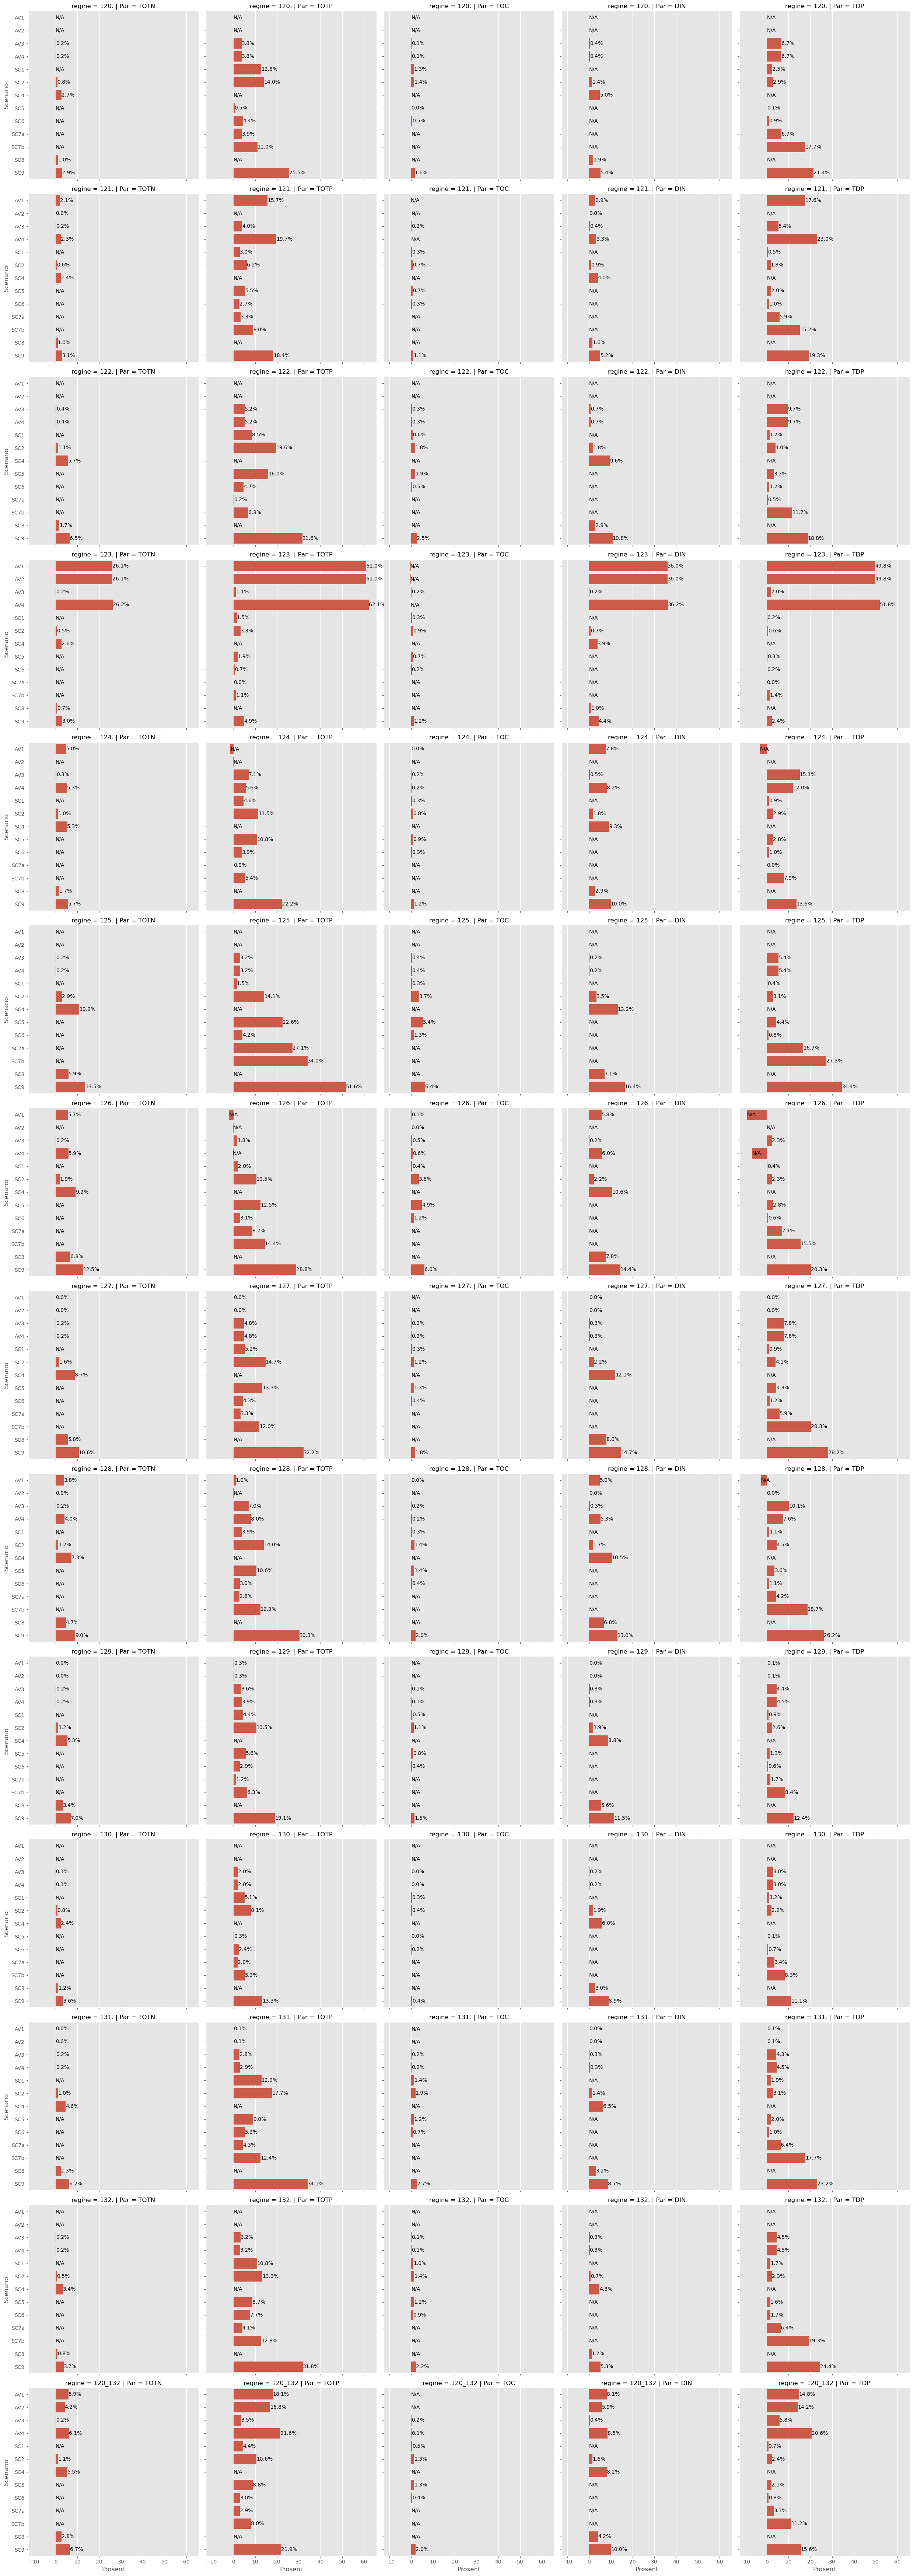

In [14]:
# Single plot for all pars and vassoms
g = sn.catplot(
    data=rel_df, x="Prosent", y="Scenario", row="regine", col="Par", kind="bar"
)
for ax in g.axes.flatten():
    for p in ax.patches:
        if p.get_width() > 0:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                f"{p.get_width():.1f}%",
                ha="left",
                va="center",
            )
        else:
            ax.text(
                p.get_width(),
                p.get_y() + p.get_height() / 2,
                "N/A",
                ha="left",
                va="center",
            )
png_path = (
    r"../results/images/pct_reductions/all_vassoms_scen_reduction_rel_baseline.png"
)
plt.savefig(png_path, dpi=200, bbox_inches="tight")

In [15]:
%%capture
# Separate plots for vassoms
for reg_id in vassom_list:
    vassom_rel_df = rel_df.query("regine == @reg_id").copy()
    g = sn.catplot(
        data=vassom_rel_df,
        x="Prosent",
        y="Scenario",
        col="Par",
        col_wrap=3,
        kind="bar",
        col_order=[par.upper() for par in pars],
        height=4,
        aspect=1.3,
    )
    g.fig.suptitle(
        f"Reduksjon i forhold til 'Baseline'",
        y=1.04,
        fontsize=16,
        fontweight="bold",
    )
    for ax in g.axes.flatten():
        for p in ax.patches:
            if p.get_width() > 0:
                ax.text(
                    p.get_width(),
                    p.get_y() + p.get_height() / 2,
                    f"{p.get_width():.1f}%",
                    ha="left",
                    va="center",
                )
            else:
                ax.text(
                    p.get_width(),
                    p.get_y() + p.get_height() / 2,
                    "N/A",
                    ha="left",
                    va="center",
                )
    if reg_id.endswith("."):
        reg_id = reg_id[:-1]
    png_path = f"../results/images/pct_reductions/vassom{reg_id}_scen_reduction_rel_baseline.png"
    plt.savefig(png_path, dpi=200, bbox_inches="tight")

## 5. Summary PDF

In [16]:
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 12)
        self.cell(0, 10, self.title, 0, 1, "C")

    def footer(self):
        self.set_y(-15)
        self.set_font("Arial", "I", 8)
        self.cell(0, 10, f"Page {self.page_no()}", 0, 0, "C")


def add_image(pdf, image_path, y_position):
    image = Image.open(image_path)
    pdf.image(image_path, x=10, y=y_position, w=190)


def create_pdf(vassom_list):
    pdf = PDF()
    pdf.set_auto_page_break(auto=True, margin=15)

    for vassom in vassom_list:
        print("Processing vassom:", vassom)
        ts_png_path = (
            f"../results/images/time_series/vassom{vassom}/vassom{vassom}_baseline.png"
        )
        src_png_path = (
            f"../results/images/baseline_inputs_by_source/vassom{vassom}_source_pct.png"
        )
        scen_png_path = f"../results/images/pct_reductions/vassom{vassom}_scen_reduction_rel_baseline.png"

        if vassom == "120_132":
            pdf.title = "Hele Trondheimsfjorden (120 - 132)"
        else:
            pdf.title = f"Vassdragsområde {vassom}"
        pdf.add_page()

        add_image(pdf, ts_png_path, 20)
        add_image(pdf, src_png_path, 165)
        add_image(pdf, scen_png_path, 225)

    pdf.output(r"../results/images/vassom_summary.pdf")


vassom_list = [f"{vassom:03d}" for vassom in vassoms] + [f"{vassoms[0]}_{vassoms[-1]}"]
create_pdf(vassom_list)

Processing vassom: 120
Processing vassom: 121
Processing vassom: 122
Processing vassom: 123
Processing vassom: 124
Processing vassom: 125
Processing vassom: 126
Processing vassom: 127
Processing vassom: 128
Processing vassom: 129
Processing vassom: 130
Processing vassom: 131
Processing vassom: 132
Processing vassom: 120_132
